In [1]:
import numpy as np
import matplotlib.pyplot as plt

import string

from models import ContinuousIncrementalRSA
from utils import *
import time
from tqdm import tqdm

# Iterated RSA
## Example 1: fix objects, utterances, semantic values and alpha 

The approach to modeling convergence to a convention is as follows:

- Initialize a `ContinuousIncrementalRSA` object. __This assumes that the objects, utterances, semantic values and alpha are all fixed, which is an assumption that we eventually will want to relax.__
- Initialize a list `counts` to keep track of the number of times a particular type of utterance (*adj-noun, noun-adj, adj only, noun only*) is produced by a pragmatic speaker.

- For each iteration:
    - For a given object, the speaker will produce a probability distribution over utterance types using continuous incremental RSA
    - Reweight that distribution by using the normalized version of `counts`
    - Sample from the reweighted distribution. 
    - Increment the utterance type that is sampled in `counts`

In [2]:
adjectives = ["red", "blue"]
nouns = ["pin", "dress"]
objects = get_all_objects(adjectives, nouns)
utterances = get_all_utterances(adjectives, nouns)
v_adj = 0.9
v_noun = 0.95
alpha = 5

In [3]:
rsa = ContinuousIncrementalRSA(adjectives=adjectives,
                                  nouns=nouns,
                                  objects=objects,
                                  utterances=utterances,
                                  v_adj=v_adj,
                                  v_noun=v_noun,
                                  alpha=alpha)

In [4]:
p_red = rsa.incremental_pragmatic_speaker({'color':'red', 'shape':'dress', 'string':'red dress'}, 'red')
p_dress = rsa.incremental_pragmatic_speaker({'color':'red', 'shape':'dress', 'string':'red dress'}, 'dress')
p_red_dress = rsa.incremental_pragmatic_speaker({'color':'red', 'shape':'dress', 'string':'red dress'}, 'red dress')
p_dress_red = rsa.incremental_pragmatic_speaker({'color':'red', 'shape':'dress', 'string':'red dress'}, 'dress red')

print('P(\'red\'| red dress) =', p_red)
print('P(\'dress\'| red dress) =', p_dress)
print('P(\'red dress\'| red dress) =', p_red_dress)
print('P(\'dress red\'| red dress) =', p_dress_red)

P('red'| red dress) = 0.01681047371800939
P('dress'| red dress) = 0.028518732723149965
P('red dress'| red dress) = 0.416024990620915
P('dress red'| red dress) = 0.5386288397613521


In [5]:
NUM_UTT_TYPES = 4
NUM_SIMS = 100
NUM_GENS = 300

runs = np.zeros(shape=(NUM_UTT_TYPES, NUM_SIMS, NUM_GENS))

for sim_idx in tqdm(range(NUM_SIMS)):
    start = time.time()
    counts = [1, 1, 1, 1]
    for gen_idx in range(NUM_GENS):
        
        #p_red = rsa.incremental_pragmatic_speaker({'color':'red', 'shape':'dress', 'string':'red dress'}, 'red')
        #p_dress = rsa.incremental_pragmatic_speaker({'color':'red', 'shape':'dress', 'string':'red dress'}, 'dress')
        #p_red_dress = rsa.incremental_pragmatic_speaker({'color':'red', 'shape':'dress', 'string':'red dress'}, 'red dress')
        #p_dress_red = rsa.incremental_pragmatic_speaker({'color':'red', 'shape':'dress', 'string':'red dress'}, 'dress red')

        utterance_type_prior = [count/sum(counts) for count in counts]
        probs = [p_red, p_dress, p_red_dress, p_dress_red]        

        #print('P(\'red\'| red dress) =', p_red)
        #print('P(\'dress\'| red dress) =', p_dress)
        #print('P(\'red dress\'| red dress) =', p_red_dress)
        #print('P(\'dress red\'| red dress) =', p_dress_red)

        denom = sum([utterance_type_prior[i]*probs[i] for i in range(4)])

        indices = list(range(4))
        normalized_probs = [(utterance_type_prior[i]*probs[i])/denom for i in range(4)]

        sample = np.random.choice(indices, p=normalized_probs)
        counts[sample] += 1

        for utt_idx in range(4):
            runs[utt_idx, sim_idx, gen_idx] = normalized_probs[utt_idx]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 348.32it/s]


In [6]:
means = []
stds = []
for i in range(4):
    mean = np.mean(runs[i], axis=0)
    std = np.std(runs[i], axis=0)
    means.append(mean)
    stds.append(std)

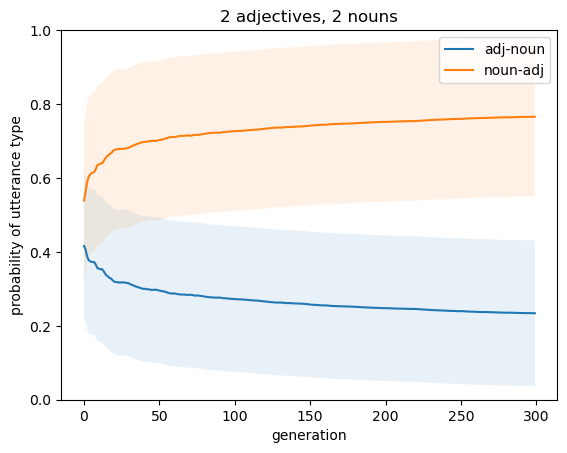

In [7]:
labels = ['adj only', 'noun only', 'adj-noun', 'noun-adj']
for i in range(2, 4):
    plt.plot(range(len(means[i])), means[i], label=labels[i])
    plt.fill_between(range(len(means[i])), means[i]+std[i], means[i]-std[i], alpha=0.1)
    
plt.legend()
plt.title("2 adjectives, 2 nouns")
plt.ylim([0, 1])
plt.xlabel('generation')
plt.ylabel('probability of utterance type')
plt.show()

Text(0, 0.5, 'frequency')

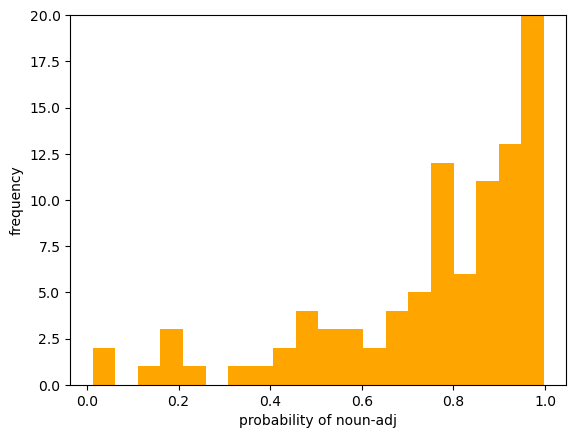

In [8]:
final_prob_of_noun_adj = runs[3, :, -1]
plt.hist(final_prob_of_noun_adj, bins=20, color='orange')
plt.ylim([0, 20])
plt.xlabel('probability of noun-adj')
plt.ylabel('frequency')

In [9]:
np.sum(final_prob_of_noun_adj < 0.5)

15

## Example 2: Sample semantic values

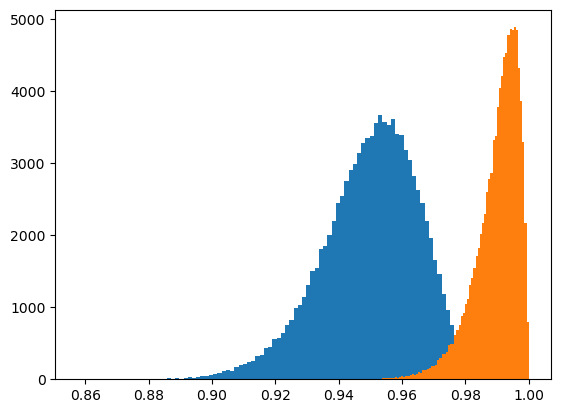

In [10]:
samples = np.random.beta(95/0.5, 5/0.5, 100000)
plt.hist(samples, bins=100)
samples = np.random.beta(99/0.5, 1/0.5, 100000)
plt.hist(samples, bins=100)
plt.show()

In [11]:
NUM_UTT_TYPES = 4
NUM_SIMS = 1000
NUM_GENS = 300

runs = np.zeros(shape=(NUM_UTT_TYPES, NUM_SIMS, NUM_GENS))

for sim_idx in tqdm(range(NUM_SIMS)):
    
    start = time.time()
    counts = [1, 1, 1, 1]
    for gen_idx in range(NUM_GENS):
        v_adj = np.random.beta(95/0.5, 5/0.5)
        v_noun = np.random.beta(99/0.5, 1/0.5)
        rsa = ContinuousIncrementalRSA(adjectives=adjectives,
                                  nouns=nouns,
                                  objects=objects,
                                  utterances=utterances,
                                  v_adj=v_adj,
                                  v_noun=v_noun,
                                  alpha=alpha)
        
        p_red = rsa.incremental_pragmatic_speaker({'color':'red', 'shape':'dress', 'string':'red dress'}, 'red')
        p_dress = rsa.incremental_pragmatic_speaker({'color':'red', 'shape':'dress', 'string':'red dress'}, 'dress')
        p_red_dress = rsa.incremental_pragmatic_speaker({'color':'red', 'shape':'dress', 'string':'red dress'}, 'red dress')
        p_dress_red = rsa.incremental_pragmatic_speaker({'color':'red', 'shape':'dress', 'string':'red dress'}, 'dress red')

        utterance_type_prior = [count/sum(counts) for count in counts]
        probs = [p_red, p_dress, p_red_dress, p_dress_red]        

        #print('P(\'red\'| red dress) =', p_red)
        #print('P(\'dress\'| red dress) =', p_dress)
        #print('P(\'red dress\'| red dress) =', p_red_dress)
        #print('P(\'dress red\'| red dress) =', p_dress_red)

        denom = sum([utterance_type_prior[i]*probs[i] for i in range(NUM_UTT_TYPES)])

        indices = list(range(NUM_UTT_TYPES))
        normalized_probs = [(utterance_type_prior[i]*probs[i])/denom for i in range(NUM_UTT_TYPES)]

        sample = np.random.choice(indices, p=normalized_probs)
        counts[sample] += 1

        for utt_idx in range(NUM_UTT_TYPES):
            runs[utt_idx, sim_idx, gen_idx] = normalized_probs[utt_idx]

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [29:41<00:00,  1.78s/it]


In [12]:
means = []
stds = []
for i in range(4):
    mean = np.mean(runs[i], axis=0)
    std = np.std(runs[i], axis=0)
    means.append(mean)
    stds.append(std)

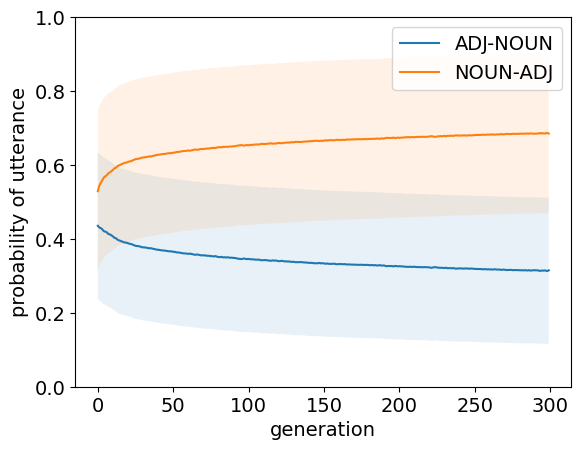

In [13]:
# Figure 4A in the paper

labels = ['red', 'pin', 'red pin', 'pin red']
labels = ['adj', 'noun', 'ADJ-NOUN', 'NOUN-ADJ']
for i in range(2, 4):
    plt.plot(range(len(means[i])), means[i], label=labels[i])
    plt.fill_between(range(len(means[i])), means[i]+std[i], means[i]-std[i], alpha=0.1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
plt.legend(fontsize=14)
plt.ylim([0, 1])
plt.xlabel('generation', fontsize=14)
plt.ylabel('probability of utterance', fontsize=14)
#plt.savefig('evolution.png')
plt.show()

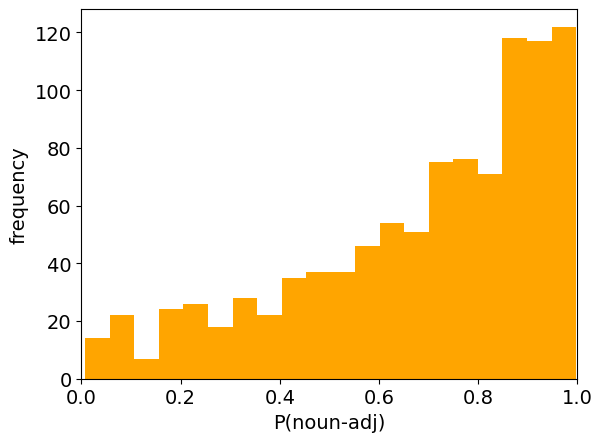

In [14]:
# Figure 4B in the paper

final_prob_of_noun_adj = runs[3, :, -1]
plt.hist(final_prob_of_noun_adj, bins=20, color='orange')
#plt.ylim([0, 20])
plt.xlim([0, 1])
plt.xlabel('P(noun-adj)', fontsize=14)
plt.ylabel('frequency', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [15]:
np.sum(final_prob_of_noun_adj < 0.48)

214

In [16]:
np.sum((final_prob_of_noun_adj < 0.52) & (final_prob_of_noun_adj >= 0.48))

36

In [17]:
np.sum(final_prob_of_noun_adj >= 0.52)

750